# Lab 1 Task 1

## 1. Implement the following layers as Python functions (both forward and backward propagation)
* Inner-product layer
* Activation layer(Sigmoid or Rectified)
* Softmax layer

In [55]:
# from google.colab import drive
# drive.mount('/content/drive')

In [56]:
# %cd /content/drive/MyDrive/AI_Lab1

In [57]:
import os
from typing import Callable, Iterable
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [58]:
class Parameter:
    def __init__(self, data: np.ndarray) -> None:
        self.data = data
        self.grad = None


class Module:
    def __call__(self, *args, **kwargs) -> np.ndarray:
        return self.forward(*args, **kwargs)

    def __repr__(self) -> str:
        layers = '\n'.join([f'  ({k}): {v}' for k, v in self.__dict__.items()])
        return f'{self.__class__.__name__}(\n{layers}\n)'

In [59]:
class Linear(Module):
    def __init__(self, in_features, out_features) -> None:
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Initialize weights and biases
        init_factor = 0.01
        self.W = Parameter(np.random.randn(in_features, out_features) * init_factor)
        self.b = Parameter(np.zeros((1, out_features)))

        # Cache for backward pass
        self.x = None

    def forward(self, x):
        # 學生實作部分：reutrn output of linear layer
        self.x = x
        output = self.x @ self.W.data + self.b.data
        
        return output

    def backward(self, dy):
        # 學生實作部分：return gradient w.r.t. input and compute gradients for weights and biases
        dx = dy @ self.W.data.T
        dw = self.x.T @ dy
        db = np.sum(dy,axis=0 ,keepdims= True)

        self.W.grad = dw
        self.b.grad = db
        
        return dx


    def parameters(self):
        return self.W, self.b

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(in_features={self.in_features}, out_features={self.out_features})'


class ReLU(Module):
    def __init__(self) -> None:
        super().__init__()
        self.x = None

    def forward(self, x):
        # 學生實作部分：return output of ReLU activation
        self.x = x

        return np.maximum(0,x)

    def backward(self, dy):
        # 學生實作部分：return gradient w.r.t. input
        dx = dy * (self.x >0)
        
        return dx
    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'


class Sigmoid(Module):
    def __init__(self) -> None:
        super().__init__()
        self.y = None

    def forward(self, x):
        # 學生實作部分：return output of Sigmoid activation
        self.y = 1/(1 + np.exp(-x))
        return self.y

    def backward(self, dy):
        # 學生實作部分：return gradient w.r.t. input
        dx = dy * self.y * (1 - self.y)

        return dx
    
    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'


class Softmax(Module):
    def __init__(self) -> None:
        super().__init__()
        self.y = None

    def forward(self, x):
        # 學生實作部分：return output of Softmax activation
        
        z = x -np.max(x,axis=1,keepdims=True)
        expz = np.exp(z)
        self.y = expz / np.sum(expz,axis = 1, keepdims=True)
        return self.y
    def backward(self, dy):
        # 這邊我們設定同學們會將Softmax和Cross-Entropy Loss一起使用
        # 因此backward pass根據講義上的說明使用簡化的版本在Cross-Entropy Loss的部分完成
        # 若同學的softmax沒有和Cross-Entropy Loss一起使用，請自行實作完整的backward pass
        return dy

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [60]:
class MLP(Module):
    def __init__(self) -> None:
        # 學生實作部分：design your Model architecture here
        in_feature = 784
        hidden1 = 128
        hidden2 = 256
        out = 10
        self.fc1 =  Linear(in_feature,hidden1)
        self.at1 = ReLU()
        self.fc2 = Linear(hidden1,hidden2)
        self.at2 = ReLU()
        self.fc3 = Linear(hidden2,out)


    def forward(self, x):
        # 學生實作部分：compute forward pass through your model
        x = self.fc1.forward(x)
        x = self.at1.forward(x)
        x = self.fc2.forward(x)
        x = self.at2.forward(x)
        x = self.fc3.forward(x)


        return x
    def backward(self, dy):
        # 學生實作部分：compute backward pass through your model
        dy = self.fc3.backward(dy)
        dy = self.at2.backward(dy)
        dy = self.fc2.backward(dy)
        dy = self.at1.backward(dy)
        dy = self.fc1.backward(dy)
        
        return dy
       
    def parameters(self):
        return self.fc1.parameters() + self.fc2.parameters() +self.fc3.parameters()

## 2. Implement training and testing process
* included cross-validation

In [61]:
class MNIST:
    # root請根據你的檔案位置更改
    def __init__(self, root='data', train=True, transform: Callable = None) -> None:
        path = os.path.join(root, 'mnist_train.csv' if train else 'mnist_test.csv')
        self.data = np.loadtxt(path, delimiter=',')
        self.transform = transform
        self.image_size = 28
        self.num_classes = 10
        self.classes = np.arange(self.num_classes)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = (self.data[idx, 0] == self.classes).astype(
            np.float32
        )  # one-hot encoding
        image = (
            self.data[idx, 1:]
            .reshape(self.image_size * self.image_size)
            .astype(np.float32)
        )
        if self.transform:
            image = self.transform(image)
        return image, label


class Subset:
    def __init__(self, dataset, indices: Iterable) -> None:
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]


class DataLoader:
    def __init__(self, dataset, batch_size=1) -> None:
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = np.arange(len(dataset))

    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size

    def __iter__(self):
        for start_idx in range(0, len(self.dataset), self.batch_size):
            end_idx = min(start_idx + self.batch_size, len(self.dataset))
            batch_indices = self.indices[start_idx:end_idx]

            batch_images = []
            batch_labels = []

            for idx in batch_indices:
                image, label = self.dataset[idx]
                batch_images.append(image)
                batch_labels.append(label)

            yield np.array(batch_images), np.array(batch_labels)

In [62]:
# Separate train_imgs, train_labels into training and validation
# root請根據你的檔案位置更改
def load_mnist_data(
    root="data", batch_size=1, split_ratio=0.1, transform=None
) -> tuple[DataLoader, DataLoader, DataLoader]:
    def _split_dataset(dataset, split_ratio):
        # 學生實作部分：split dataset into training and validation sets
        # hint: return Subset(dataset, train_indices), Subset(dataset, valid_indices)
        np.random.seed(23)
        total = len(dataset)
        ind = np.random.permutation(total)
        split = int(total * (1-split_ratio))
        train_indices = ind[:split]
        valid_indices = ind[split:]

        return Subset(dataset,train_indices) ,Subset(dataset,valid_indices)
        
        

    trainset = MNIST(root=root, train=True, transform=transform)
    testset = MNIST(root=root, train=False, transform=transform)
    trainset, validset = _split_dataset(trainset, split_ratio=split_ratio)
    trainldr = DataLoader(trainset, batch_size=batch_size)
    validldr = DataLoader(validset, batch_size=batch_size)
    testldr = DataLoader(testset, batch_size=batch_size)
    return trainldr, validldr, testldr

In [63]:
class CrossEntropyLoss(Module):
    def __init__(self, epsilon=1e-15) -> None:
        super().__init__()
        self.epsilon = epsilon  # small value to avoid log(0)
        self.y_pred = None
        self.y_true = None

    def forward(self, y_pred, y_true):
        self.y_pred = np.clip(y_pred, self.epsilon, 1 - self.epsilon)
        self.y_true = y_true
        batch_size = y_true.shape[0]
        loss = -np.sum(y_true * np.log(self.y_pred)) / batch_size
        return loss

    def backward(self):
        batch_size = self.y_true.shape[0]
        grad = (self.y_pred - self.y_true) / batch_size
        return grad

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"


class SGD:
    def __init__(self, params: Iterable, lr: float = 1e-3) -> None:
        self.params = params
        self.lr = lr

    def step(self):
        for param in self.params:
            if param.grad is not None:
                param.data -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.fill(0)

In [64]:
def train_one_epoch(model: Module, trainldr: Iterable, criterion, optimizer) -> tuple[float, float]:
    total = 0
    correct = 0
    total_loss = 0
    for x, y in tqdm(trainldr):
        # 學生實作部分：complete the training process through one epoch
        
        # Hint:
        # 1. forward propagation
        y_pred = model.forward(x)
        
        # 2. compute loss
        loss = criterion(y_pred,y)
        total_loss += loss * len(y)
        # 3. compute accuracy
        pred_lab = np.argmax(y_pred,axis=1)
        true_lab = np.argmax(y, axis=1)
        correct += np.sum(pred_lab == true_lab)
        total += len(y)
        # 4. backward propagation
        dy = criterion.backward()
        model.backward(dy)
        # 5. update parameters
        optimizer.step()
        optimizer.zero_grad()
        


    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model: Module, testldr: Iterable) -> tuple[float, float]:
    total = 0
    correct = 0
    total_loss = 0
    criterion = CrossEntropyLoss()  # separate criterion from training
    for x, y in tqdm(testldr):
        # 學生實作部分：complete the evaluation process
        # Hint:
        # 1. forward propagation
        y_pred = model.forward(x)
        # 2. compute total loss
        loss = criterion(y_pred,y)
        total_loss += loss * len(y)
        # 3. compute correct and total
        pred_lab = np.argmax(y_pred,axis=1)
        true_lab = np.argmax(y, axis=1)
        correct += np.sum(pred_lab == true_lab)
        total += len(y)
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def train(model: MLP, trainldr: Iterable, validldr: Iterable, epochs=10, lr=1e-3):
    criterion = CrossEntropyLoss()
    # 這邊提供SGD作為optimizer，同學也可以根據自己人需求更換其他optimizer
    optimizer = SGD(model.parameters(), lr=lr)
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):
        loss, acc = train_one_epoch(model, trainldr, criterion, optimizer)
        train_loss.append(loss)
        train_acc.append(acc)
        print(f'epoch {epoch:d}: train_loss = {loss}, train_acc = {acc}')

        loss, acc = evaluate(model, validldr)
        valid_loss.append(loss)
        valid_acc.append(acc)
        print(f'epoch {epoch:d}: valid_loss = {loss}, valid_acc = {acc}\n')

    return train_loss, train_acc, valid_loss, valid_acc

In [65]:
def transform(x):
    """map pixels information from range(0, 255) to range(0.01, 1)"""
    return np.asarray(x) * 0.99 + 0.01

# "../data"請根據你的檔案位置更改
trainldr, validldr, testldr = load_mnist_data(
    "data", batch_size=1, transform=transform
)

print(f"train set: {len(trainldr)} images")
print(f"validation set: {len(validldr)} images")
print(f"test set: {len(testldr)} images")
for x, y in trainldr:
    print(f"x shape: {x.shape}")
    print(f"y shape: {y.shape}")
    break

net = MLP()
print(net)
train_loss, train_acc, valid_loss, valid_acc = train(
    net, trainldr, validldr, epochs = 10, lr=0.0001
)

train set: 54000 images
validation set: 6000 images
test set: 10000 images
x shape: (1, 784)
y shape: (1, 10)
MLP(
  (fc1): Linear(in_features=784, out_features=128)
  (at1): ReLU()
  (fc2): Linear(in_features=128, out_features=256)
  (at2): ReLU()
  (fc3): Linear(in_features=256, out_features=10)
)


100%|██████████| 54000/54000 [01:11<00:00, 755.25it/s]


epoch 0: train_loss = 0.9152028934393206, train_acc = 0.9183148148148148


100%|██████████| 6000/6000 [00:00<00:00, 7221.29it/s]


epoch 0: valid_loss = 0.4568483974265892, valid_acc = 0.9533333333333334



100%|██████████| 54000/54000 [01:07<00:00, 803.76it/s]


epoch 1: train_loss = 0.4090664536161763, train_acc = 0.9637962962962963


100%|██████████| 6000/6000 [00:00<00:00, 6455.99it/s]


epoch 1: valid_loss = 0.3189424872010316, valid_acc = 0.966



100%|██████████| 54000/54000 [01:08<00:00, 792.02it/s]


epoch 2: train_loss = 0.29662697987078884, train_acc = 0.9733888888888889


100%|██████████| 6000/6000 [00:00<00:00, 7297.23it/s]


epoch 2: valid_loss = 0.2674099353220783, valid_acc = 0.9705



100%|██████████| 54000/54000 [01:10<00:00, 771.10it/s]


epoch 3: train_loss = 0.21759167414832048, train_acc = 0.9801481481481481


100%|██████████| 6000/6000 [00:00<00:00, 7315.99it/s]


epoch 3: valid_loss = 0.25697897709641687, valid_acc = 0.9736666666666667



100%|██████████| 54000/54000 [01:09<00:00, 775.21it/s]


epoch 4: train_loss = 0.164786792227697, train_acc = 0.9843333333333333


100%|██████████| 6000/6000 [00:00<00:00, 7518.98it/s]


epoch 4: valid_loss = 0.25257692407341015, valid_acc = 0.9768333333333333



100%|██████████| 54000/54000 [01:11<00:00, 756.11it/s]


epoch 5: train_loss = 0.13275231480440658, train_acc = 0.987537037037037


100%|██████████| 6000/6000 [00:00<00:00, 7272.18it/s]


epoch 5: valid_loss = 0.2535311923205799, valid_acc = 0.9776666666666667



100%|██████████| 54000/54000 [01:10<00:00, 770.96it/s]


epoch 6: train_loss = 0.10366631935681646, train_acc = 0.9901666666666666


100%|██████████| 6000/6000 [00:00<00:00, 7164.36it/s]


epoch 6: valid_loss = 0.26027885024160835, valid_acc = 0.9783333333333334



100%|██████████| 54000/54000 [01:08<00:00, 790.66it/s]


epoch 7: train_loss = 0.0784155543580072, train_acc = 0.9921111111111112


100%|██████████| 6000/6000 [00:01<00:00, 5579.42it/s]


epoch 7: valid_loss = 0.27815027043649654, valid_acc = 0.9793333333333333



100%|██████████| 54000/54000 [01:06<00:00, 810.71it/s]


epoch 8: train_loss = 0.064897059998663, train_acc = 0.9935185185185185


100%|██████████| 6000/6000 [00:00<00:00, 6894.44it/s]


epoch 8: valid_loss = 0.2913774879714576, valid_acc = 0.9791666666666666



100%|██████████| 54000/54000 [01:08<00:00, 787.76it/s]


epoch 9: train_loss = 0.05025896775193759, train_acc = 0.9953148148148148


100%|██████████| 6000/6000 [00:00<00:00, 7645.46it/s]

epoch 9: valid_loss = 0.29220605268871, valid_acc = 0.9795



In [66]:
# Using test_images and test_labels to do the final test
test_loss, test_acc = evaluate(net, testldr)
print(f"test_loss = {test_loss}, test_acc = {test_acc}")

100%|██████████| 10000/10000 [00:01<00:00, 7176.94it/s]

test_loss = 0.3436143329092287, test_acc = 0.9786


## 3. Plot loss & accuracy curves(both Training and Validation)

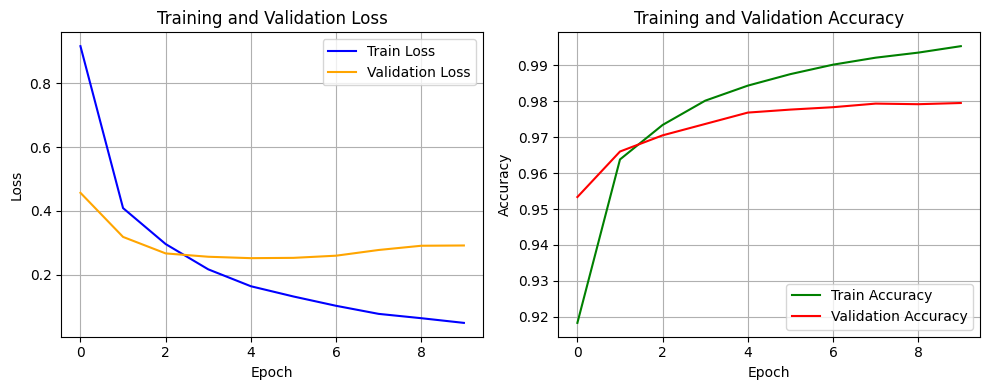

In [67]:
# Plot training and validation loss and accuracy curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(valid_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy', color='green')
plt.plot(valid_acc, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()


plt.show()